# Exploratory Analysis

This notebook contains decisions in the exploratory analysis process of the Austin crime project.

## The Required Imports

Here we'll import all the modules required to run the code cells in this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_crime_data
from prepare import split_data
from explore import *

## Acquire and Prepare Data

Here we'll acquire and prepare the data using the wrangle module.

In [2]:
df = wrangle_crime_data()
df.shape

Using cached csv


(349581, 17)

## Split the Data

Now we will need to split the data before we begin exploring because we will now begin exploring the relationship between the target variable and other features in the data.

In [3]:
train, validate, test = split_data(df)
train.shape, validate.shape, test.shape

((195764, 17), (83900, 17), (69917, 17))

From here on we'll only use the train variable.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195764 entries, 128272 to 382883
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   crime_type        195764 non-null  object        
 1   family_violence   195764 non-null  object        
 2   occurrence_time   195764 non-null  datetime64[ns]
 3   occurrence_date   195764 non-null  datetime64[ns]
 4   report_time       195764 non-null  datetime64[ns]
 5   report_date       195764 non-null  datetime64[ns]
 6   location_type     195764 non-null  object        
 7   address           195764 non-null  object        
 8   zip_code          195764 non-null  float64       
 9   council_district  195764 non-null  float64       
 10  sector            195764 non-null  object        
 11  district          195764 non-null  object        
 12  latitude          195764 non-null  float64       
 13  longitude         195764 non-null  float64       
 14 

## Does the difference between time of incident and report time relate to a crime being solved/closed?

In this notebook we're going to explore the relationship between the clearance status of a case and the difference in time between when the incident occurred and when the incident was reported.

### Engineer Time Difference Feature

In order to answer this question we will need to create a feature which contains the difference in time between when a crime occurred and when it was reported.

In [5]:
train['time_to_report'] = train.report_time - train.occurrence_time
train.time_to_report.head()

128272   0 days 07:16:00
420369   0 days 00:00:00
79483    1 days 19:54:00
430217   6 days 00:00:00
280218   0 days 15:34:00
Name: time_to_report, dtype: timedelta64[ns]

Now we have the difference between the time when a crime was reported and when it occurred, but we may need to bin this column to help with exploration. There are a lot of unique values in here so in order to gain meaningful insights from this feature we will need to create bins.

### Binning the Time to Report Column

We'll need to create bins for our data to make exploration easier. We'll create 6 distinct bins: No difference in occurrence and report time, 1 minute - 1 hour, 1 hour - 6 hours, 6 hours - 1 day, 1 day - 1 week, and greater than 1 week.

In [6]:
train['time_to_report_bins'] = pd.cut(
    train.time_to_report,
    [
        pd.Timedelta('-1d'),
        pd.Timedelta('59s'),
        pd.Timedelta('59m'),
        pd.Timedelta('6h'),
        pd.Timedelta('1d'),
        pd.Timedelta('7d'),
        pd.Timedelta('10y')
    ],
    labels = [
        'No difference',
        '1 minute - 1 hour',
        '1 hour - 6 hours',
        '6 hours - 1 day',
        '1 day - 1 week',
        'Greater than 1 week'
    ]
)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
train.time_to_report_bins.value_counts()

No difference          81774
6 hours - 1 day        30133
1 day - 1 week         28036
1 hour - 6 hours       24249
Greater than 1 week    16245
1 minute - 1 hour      15327
Name: time_to_report_bins, dtype: int64

### Visualize the Results

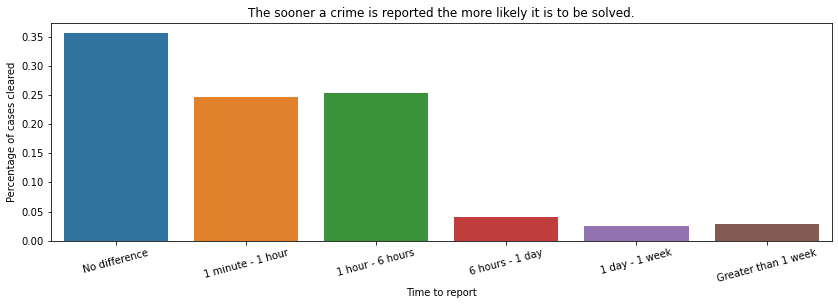

In [8]:
plt.figure(figsize = (14, 4))

sns.barplot(
    data = train,
    x = 'time_to_report_bins',
    y = 'cleared',
    ci = None
)

plt.xticks(rotation = 15)

plt.xlabel('Time to report')
plt.ylabel('Percentage of cases cleared')

plt.title('The sooner a crime is reported the more likely it is to be solved.');

#### Takeaways

From the visualization we can determine that the clearance status of a case does depend on the amount time between when the crime occurred and when it was reported. We can verify the significance of this finding with a statistical test.

### Stats Test

We'll be testing the following hypothesis:

$H_0$: The clearance status of a case is independent of the difference in time between when a crime occurred and when it was reported.
<br>
$H_a$: The clearance status of a case is dependent on the difference in time between when a crime occurred and when it was reported.

In [9]:
chi2(train.time_to_report_bins, train.cleared)

The chi2 value between the two variables is 25046.03220200103 and the P-Value is 0.0.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.


**Takeaways:**
<br>
The results are that we reject the null hypothesis meaning that the clearance status of a case is dependent on the time to report the crime.

For robustness let's also test this differently:

$H_0$: The average number of cases cleared for cases with time to report less than 6 hours is equal to the average number of cases cleared for cases with time to report greater than 6 hours.
<br>
$H_a$: The average number of cases cleared for cases with time to report less than 6 hours is greater than the average number of cases cleared for cases with time to report greater than 6 hours.

In [10]:
time_to_report_less_than_6hrs = train.time_to_report <= pd.Timedelta('6h')
time_to_report_greater_than_6hrs = train.time_to_report > pd.Timedelta('6h')

t_test_ind(
    train[time_to_report_less_than_6hrs].cleared,
    train[time_to_report_greater_than_6hrs].cleared,
    alternative = 'greater'
)

The t value between the two samples is 162.5 and the P-Value is 0.0.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.


**Takeaways:**
<br>
The results are that we reject the null hypothesis meaning that cases with a time to report less than 6 hours have on average more cleared cases than cases with a time to report greater than 6 hours.

## Multivariate Analysis

I'm interested in determining whether or not other variables will have an influence on the dependency between time to report and clearance status. The following variables will be investigated: council district, crime type, and location type.

### Council District

Let's explore how introducing the council_district feature affects the dependency between time_to_report and clearance_status.

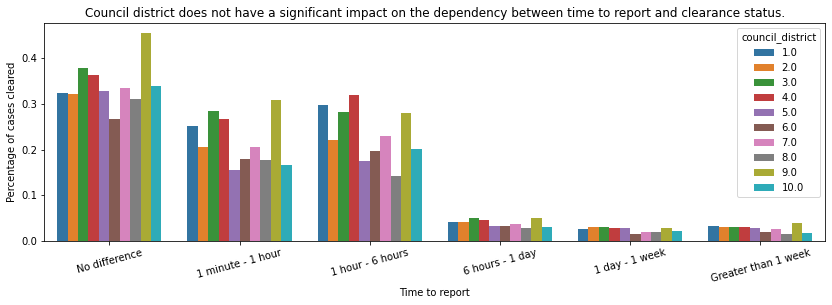

In [11]:
plt.figure(figsize = (14, 4))

sns.barplot(
    data = train,
    x = 'time_to_report_bins',
    y = 'cleared',
    ci = None,
    hue = 'council_district'
)

plt.xticks(rotation = 15)

plt.xlabel('Time to report')
plt.ylabel('Percentage of cases cleared')

plt.title('Council district does not have a significant impact on the dependency between time to report and clearance status.');

Let's now verify the significance of this finding with some stats tests. We'll run a test for each council district. The hypotheses will be of the following format:

$H_0$: In council district N the average number of cases cleared for cases with time to report less than 6 hours is equal to the average number of cases cleared for cases with time to report greater than 6 hours.
<br>
$H_a$: In council district N the average number of cases cleared for cases with time to report less than 6 hours is greater than the average number of cases cleared for cases with time to report greater than 6 hours.

In [12]:
time_to_report_less_than_6hrs = train.time_to_report <= pd.Timedelta('6h')
time_to_report_greater_than_6hrs = train.time_to_report > pd.Timedelta('6h')

for council_district in train.council_district.unique():
    print(f'Council District: {council_district}')
    obs_in_council_district_n = train.council_district == council_district
    
    t_test_ind(
        train[time_to_report_less_than_6hrs & obs_in_council_district_n].cleared,
        train[time_to_report_greater_than_6hrs & obs_in_council_district_n].cleared,
        alternative = 'greater'
    )
    print()

Council District: 3.0
The t value between the two samples is 62.16 and the P-Value is 0.0.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.

Council District: 9.0
The t value between the two samples is 76.98 and the P-Value is 0.0.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.

Council District: 5.0
The t value between the two samples is 44.57 and the P-Value is 0.0.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.

Council District: 2.0
The t value between the two samples is 44.04 and the P-Value is 0.0.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.

Council District: 10.0
The t val

#### Takeaways

The results are that for each council district we reject the null hypothesis meaning that regardless of council district cases with a time to report less than 6 hours on average have more cleared cases than cases with time to report greater than 6 hours.

### Crime Type

Let's now investigate how crime type affects the dependency between clearance status and time to report.

In [13]:
# Due to the large number of crime type categories, for exploration purposes we'll use only the top
# 10 crime categories.

top_10_crimes = [
    'DWI',
    'ASSAULT WITH INJURY',
    'THEFT BY SHOPLIFTING',
    'HARASSMENT',
    'AUTO THEFT',
    'ASSAULT W/INJURY-FAM/DATE VIOL',
    'CRIMINAL MISCHIEF',
    'FAMILY DISTURBANCE',
    'THEFT',
    'BURGLARY OF VEHICLE'
]

# Create a subsetted df that only includes the top 10 crimes
top_crimes_df = train.copy()
top_crimes_df = top_crimes_df[top_crimes_df.crime_type.isin(top_10_crimes)]

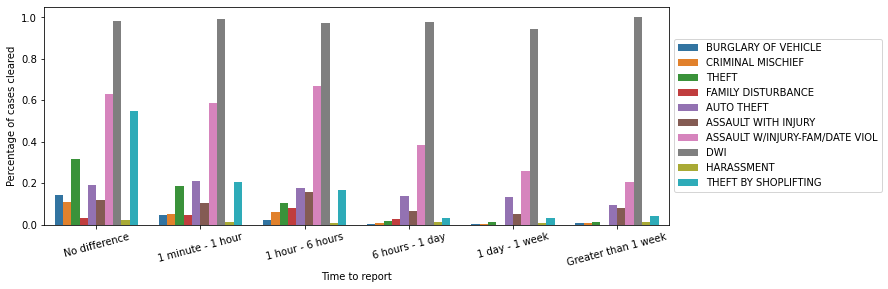

In [14]:
plt.figure(figsize = (14, 4))

ax = sns.barplot(
    data = top_crimes_df,
    x = 'time_to_report_bins',
    y = 'cleared',
    ci = None,
    hue = 'crime_type'
)

plt.xticks(rotation = 15)

plt.xlabel('Time to report')
plt.ylabel('Percentage of cases cleared')

plt.title('')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

It's a little difficult to see the results for some of these crime types. Let's split these up into different plots.

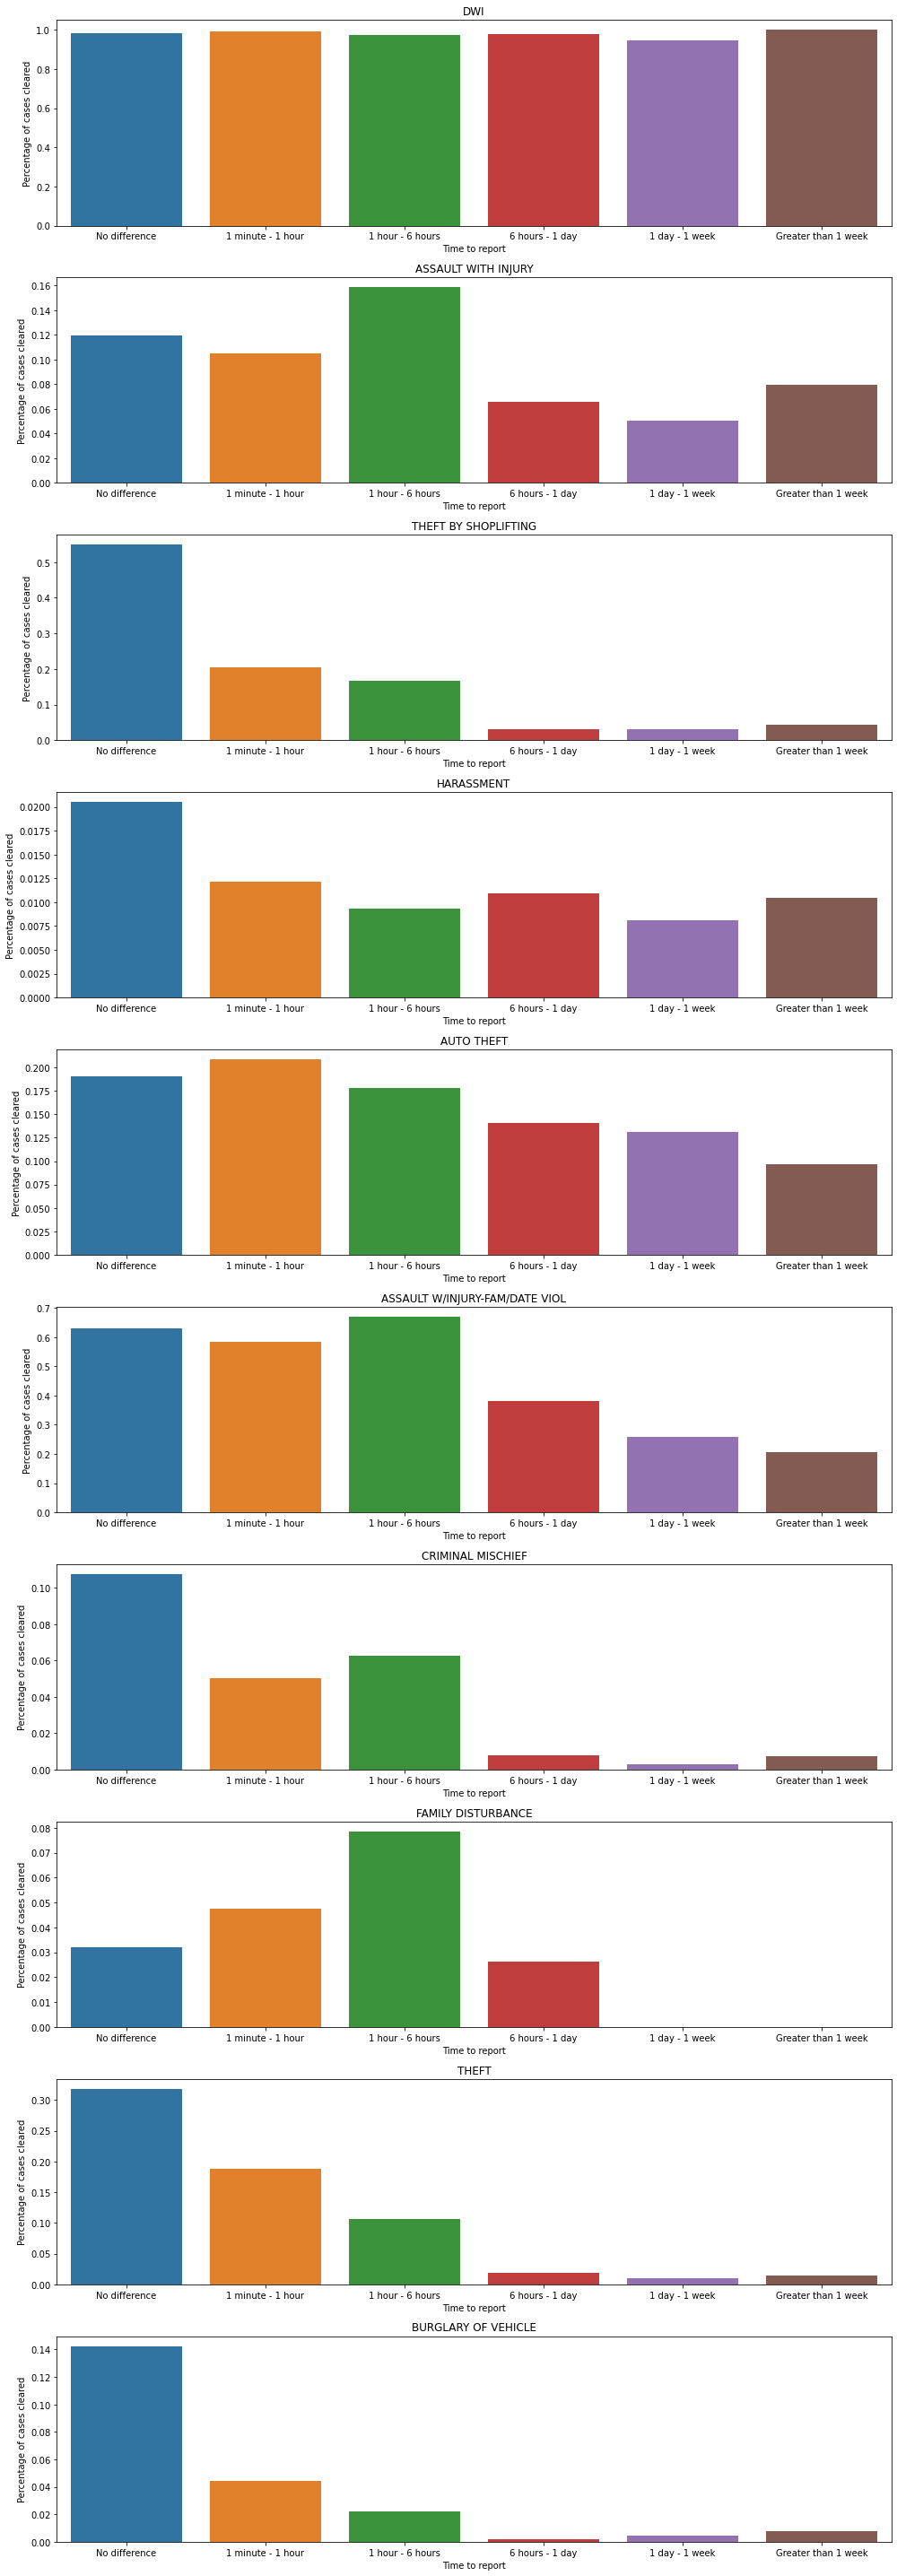

In [15]:
fig, ax = plt.subplots(nrows = 10, ncols = 1, figsize = (14, 40))

for index, crime_type in enumerate(top_10_crimes):
    sns.barplot(
        data = train[train.crime_type == crime_type],
        x = 'time_to_report_bins',
        y = 'cleared',
        ci = None,
        ax = ax[index]
    )

    ax[index].set_xlabel('Time to report')
    ax[index].set_ylabel('Percentage of cases cleared')

    ax[index].set_title(crime_type)
    
plt.tight_layout();

Let's conduct some stats tests to see for how many crime type categories the dependency of clearance status and time to report holds true. We'll test the following hypothesis:

$H_0$: For crime type N the average number of cases cleared for cases with time to report less than 6 hours is equal to the average number of cases cleared for cases with time to report greater than 6 hours.
<br>
$H_a$: For crime type N the average number of cases cleared for cases with time to report less than 6 hours is greater than the average number of cases cleared for cases with time to report greater than 6 hours.

In [16]:
time_to_report_less_than_6hrs = train.time_to_report <= pd.Timedelta('6h')
time_to_report_greater_than_6hrs = train.time_to_report > pd.Timedelta('6h')

for crime_type in train.crime_type.unique():
    print(f'Council District: {crime_type}')
    obs_for_crime_type_n = train.crime_type == crime_type
    
    t_test_ind(
        train[time_to_report_less_than_6hrs & obs_for_crime_type_n].cleared,
        train[time_to_report_greater_than_6hrs & obs_for_crime_type_n].cleared,
        alternative = 'greater'
    )
    print()

Council District: IDENTITY THEFT
The t value between the two samples is 7.268 and the P-Value is 2.2508509373393677e-13.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.

Council District: POSS CONTROLLED SUB/NARCOTIC
The t value between the two samples is 1.128 and the P-Value is 0.12980085548782286.
----------------------------------------------------------------------------
Since the P value is greater than the alpha, we fail to reject the null hypothesis.

Council District: BURGLARY OF VEHICLE
The t value between the two samples is 27.3 and the P-Value is 2.5617051792554787e-161.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.

Council District: INTERFERENCE PUBLIC DUTIES
The t value between the two samples is -0.5794 and the P-Value is 0.7171801419052835.
--------------------------

/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The t value between the two samples is nan and the P-Value is nan.
----------------------------------------------------------------------------
Since the P value is greater than the alpha, we fail to reject the null hypothesis.

Council District: POSS CONTROLLED SUB/SYN NARC
The t value between the two samples is -0.6678 and the P-Value is 0.747280383895427.
----------------------------------------------------------------------------
Since the P value is greater than the alpha, we fail to reject the null hypothesis.

Council District: DOC ABUSE OR THREAT
The t value between the two samples is 0.504 and the P-Value is 0.31058142834464675.
----------------------------------------------------------------------------
Since the P value is greater than the alpha, we fail to reject the null hypothesis.

Council District: POSS OF PROHIBITED WEAPON
The t value between the two samples is nan and the P-Value is nan.
----------------------------------------------------------------------------
Sinc

#### Takeaways

For the most part, each crime type follows the same pattern where the average number of cases solved decreases as time to report increases with two exceptions. DWI cases seem to always get cleared regardless of time to report. Family disturbance cases are much more sporadic with large percentages of solved cases for time to report of 1 hour - 6 hours and greater than 1 week.